In [1]:
#import library for getting folders
import glob

#import library for dataframe
import pandas as pd
import numpy as np
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd

############# Libraries for Natural Language Processing #############
#Libraries used for Pre-Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Library for sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import requests
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer

#######################################################



import re

#Library for visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud



## Setting GitHub Credentials

In [2]:
username = "GreyScaling"
repo_name = "UOB-Financial-Loan-Analysis"

# Specify the folder path (e.g., "path/to/folder")
folder_path = "csvs"

In [3]:
def get_filenames(username , repo_name , folder_path):

    '''

    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     '''

    url = f"https://api.github.com/repos/{username}/{repo_name}/contents/{folder_path}"
    csv_path = f'https://raw.githubusercontent.com/{username}/{repo_name}/main/{folder_path}/'


    filenames = []
    response = requests.get(url)

    #Checks if the url is OK
    if response.status_code == 200:
        data = response.json()
        for item in data:
            # Check if the item is a file and ends with ".csv" extension
            if item["type"] == "file" and item["name"].endswith(".csv"):

                #Attach the folder path together with the filename get the entire url  
                filename = csv_path + item['name']
                filenames.append(filename)
    else:
        print(f"Error: {response.status_code}")

    return(filenames)

In [4]:
print(get_filenames.__doc__)



    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     


In [5]:
#Return a list of the filepaths
csvs = get_filenames(username , repo_name , folder_path)

In [6]:
#Read all the files into a single dataframe
df = dd.read_csv(csvs).compute().reset_index(drop=True)

In [7]:
#Remove any row that has no content 
df = df[df['Content'].str.strip() != '']
#Remove any null Rows 
df.dropna(inplace =True)

In [8]:
def lemmatize_words(text):
    """ function to lemmatize the words"""    
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [9]:
def pre_process(dataframe):
    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Removing Stopwords
        3) Removing single alphabets
        4) Removing WhiteSpace
        5) Removing Punctuations
        6) Removing Emojis & other image related symbolds
        7) Lemmatizing the words

    '''
    
    #converts text to lowercase
    dataframe['Content'] = dataframe['Content'].apply(lambda x: x.lower())

    #Remove all punctuations
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('[^\w\s]', ' ', x))

    #Remove all stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'singapore', 'malaysia' , 'said' ,','])
    dataframe['Content'] = dataframe['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Removing Numbers
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\d+' , '' , x))

    #remove single alphabets
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\b[a-zA-Z]\s', ' ' , x))

    #remove Hyperlinks
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("<.*?>+|https?://\S+|www\.\S+", " " , x))

    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("/^\s+|\s+$|\s+(?=\s)/g", "" , x))


    #Removing Emojis and any other image related symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoji
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    
    dataframe['Content'] = dataframe['Content'].apply(lambda x: emoji_pattern.sub(r' ', x))

    #Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    dataframe['Content'] = dataframe['Content'].apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split(' ')]) ) 



In [10]:
pre_process(df)

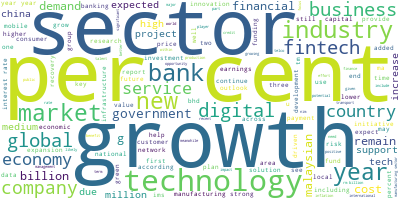

In [11]:
# Join the different processed titles together.
long_string = ','.join(list(df['Content'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [12]:
def get_top_n_words(n_top_words, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample

    Args:
    - n_top_words (int): Number of top words to retrieve
    - text_data (pandas.Series): Series containing text data
    
    Returns:
    - tuple: A tuple containing two elements:
             1. List of top n words
             2. List of counts corresponding to the top n words
    '''
    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer(stop_words='english')
    
    # Vectorize the headlines
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    
    # Sum up the vectorized words
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    
    # Get indices of sorted words
    word_indices = np.flip(np.argsort(vectorized_total)[0, :], 1)
    
    # Get sorted word counts
    word_values = np.flip(np.sort(vectorized_total)[0, :], 1)
    
    # Initialize word vectors
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    
    # Populate word vectors
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    # Get words from indices
    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0, :n_top_words].tolist()[0])


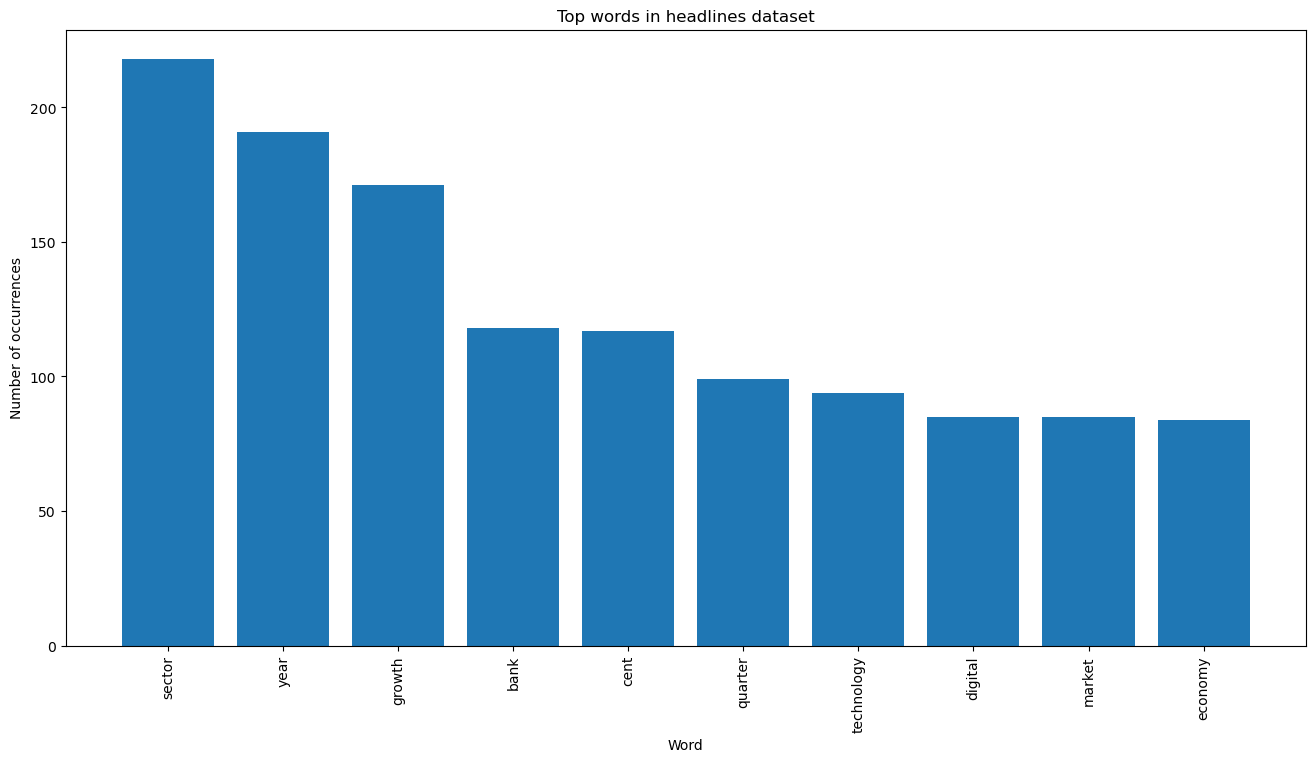

In [13]:
# Get the top n words and their counts
words, word_values = get_top_n_words(n_top_words=10, text_data=df['Content'])

# Plot the top words
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurrences')
plt.show()


In [ ]:
headlines_array = np.array(df['Content'])
headlines_list = list(headlines_array)

In [ ]:
def sentiment_dataframe(predictions):
    

    #Headline #Positive #Negative #Neutral
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {'Headline':headlines_list,
            "Positive":positive,
            "Negative":negative, 
            "Neutral":neutral}
        
    dataframe = pd.DataFrame(table)

    return dataframe

In [ ]:
def get_sentiments(pretrained_model):
    """
    Analyzes the sentiment of a list of headlines using a pre-trained transformer model.

    Args:
        pretrained_model (str): Name of the pre-trained model from the Hugging Face model hub.

    Returns:
        dataFrame: A DataFrame containing the sentiment analysis results.

        """

    # Load pre-trained tokenizer and model for sentiment classification
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

    # Prepare text inputs with padding, truncation, and conversion to PyTorch tensors
    inputs = tokenizer(headlines_list, padding=True, truncation=True, return_tensors="pt")

    # Get model predictions (logits) and apply softmax for probability distribution
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Create DataFrame to present sentiment analysis results using 'sentiment_dataframe' function
    dataframe = sentiment_dataframe(predictions)

    return dataframe


In [ ]:
finbert_sentiments = get_sentiments("ProsusAI/finbert")
financial_sentiments = get_sentiments("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sigma_sentiments = get_sentiments("Sigma/financial-sentiment-analysis")

In [ ]:
def get_sentimentsII(row, pipeline):
    '''
    Analyzes the sentiment of a content row using a pre-defined sentiment analysis pipeline.

    Args:
    - row (pandas.Series): Row containing the content to analyze
    - pipeline: Pre-defined sentiment analysis pipeline

    Returns:
    - pandas.Series: Updated row with sentiment analysis results added as 'sentiment' and 'sentiment_score'
    '''
    # Extract content from the row
    content = row['Content']
    
    # Perform sentiment analysis using the provided pipeline
    result = pipeline(content)
    
    # Add sentiment analysis results to the row
    row['sentiment'] = result[0]['label']
    row['sentiment_score'] = result[0]['score']
    
    return row


In [ ]:
# Define a sentiment analysis pipeline using the "soleimanian/financial-roberta-large-sentiment" model
soleimanian_pipeline = pipeline("sentiment-analysis", 
                                model="soleimanian/financial-roberta-large-sentiment", 
                                tokenizer="soleimanian/financial-roberta-large-sentiment", 
                                max_length=512, 
                                truncation=True)

# Define a sentiment analysis pipeline using the "yiyanghkust/finbert-tone" model
yiyangkhust_pipeline = pipeline("sentiment-analysis", 
                                model="yiyanghkust/finbert-tone", 
                                tokenizer="yiyanghkust/finbert-tone", 
                                max_length=512, 
                                truncation=True)


In [ ]:
soleimanian_sentimens = df.apply(get_sentimentsII, pipeline=soleimanian_pipeline, axis=1)
yiyangkhost_df = df.apply(get_sentimentsII, pipeline=yiyangkhust_pipeline, axis=1)

In [ ]:
yiyangkhost_df.head()

,Title,Content,Site-Name,sentiment,sentiment_score
0,Malaysia: A Flourishing Fintech Ecosystem,malaysian embraced financial technology common...,imf,Positive,0.999826
1,Fintech Report 2022: Malaysia Charts a New Pat...,regulator policymakers actively supporting fin...,fintechnews,Positive,0.999999
3,Loan growth to closely track GDP,petaling jaya malaysian banking sector bellwet...,thestar,Positive,0.999998
4,Analysts mixed on banking sector’s valuations ...,kuala lumpur jan investment analyst shared mi...,theedgemalaysia,Positive,1.000000
5,Malaysia central bank maintains 2023 growth fo...,kuala lumpur central bank wednesday mar maint...,channelnewsasia,Positive,0.995942


In [ ]:
soleimanian_sentimens.merge(yiyangkhost_df[['Content','sentiment' , 'sentiment_score']], how='outer', on='Content' ,suffixes=(' _soleimanian', '_yiyang,'))

,Title,Content,Site-Name,sentiment _soleimanian,sentiment_score _soleimanian,"sentiment_yiyang,","sentiment_score_yiyang,"
0,MAS Commits Up To S$150 million for Technology...,august monetary authority ma today announced...,mas,positive,0.998092,Positive,0.999975
1,Blueprint to help Malaysia achieve digital eco...,nov technology continues drive advance throu...,mida,positive,0.997550,Positive,0.999930
2,HIGHEST GROWTH IN PROFIT AFTER TAX OVER THREE ...,article first appeared edge weekly november ...,theedgemalaysia,positive,0.997219,Positive,0.999999
3,Singapore banks face challenging outlook as lo...,bank likely face muted result second half hig...,spglobal,negative,0.998082,Positive,0.981034
4,TIPPING POINT FOR MALAYSIA AND TELCO INDUSTRY,beyond promise g bringing faster home broadban...,thestar,positive,0.997783,Positive,0.999999
5,Singapore ICT sector: Driving the Nation’s Eco...,big infocomm technology ict sector one world w...,mycareersfuture,positive,0.998143,Positive,1.000000
6,New S$55m media funding aims to enhance virtua...,channelling fund medium landscape help local c...,channelnewsasia,positive,0.996968,Positive,0.812696
7,Tech sector outlook remains uncertain,click enlarge kuala lumpur significant rebound...,thestar,negative,0.997986,Positive,0.998249
8,Singapore’s digital economy – from e-commerce ...,digital economy contributed gross domestic pr...,cnbc,positive,0.998157,Positive,0.999998
9,Singapore’s economy grew 2.8% in Q4 as manufac...,economy gained momentum fourth quarter amid r...,channelnewsasia,positive,0.997925,Positive,0.999025


In [ ]:
soleimanian_sentimens.sentiment.value_counts()

sentiment
positive    24
negative    15
neutral      2
Name: count, dtype: int64

In [ ]:
financial_sentiments.head(5)

,Headline,Positive,Negative,Neutral
0,malaysian embraced financial technology common...,0.000203,0.000281,0.999517
1,regulator policymakers actively supporting fin...,0.000180,0.000152,0.999668
2,petaling jaya malaysian banking sector bellwet...,0.000253,0.000140,0.999607
3,kuala lumpur jan investment analyst shared mi...,0.005176,0.000310,0.994514
4,kuala lumpur central bank wednesday mar maint...,0.001945,0.000141,0.997914


In [ ]:
sigma_sentiments.head(5)

,Headline,Positive,Negative,Neutral
0,malaysian embraced financial technology common...,0.015902,0.095215,0.888882
1,regulator policymakers actively supporting fin...,0.008524,0.040788,0.950688
2,petaling jaya malaysian banking sector bellwet...,0.010910,0.021283,0.967808
3,kuala lumpur jan investment analyst shared mi...,0.167920,0.226958,0.605121
4,kuala lumpur central bank wednesday mar maint...,0.044103,0.068929,0.886967


In [ ]:
finbert_sentiments.head(5)

,Headline,Positive,Negative,Neutral
0,malaysian embraced financial technology common...,0.128801,0.016848,0.854351
1,regulator policymakers actively supporting fin...,0.356630,0.028099,0.615271
2,petaling jaya malaysian banking sector bellwet...,0.185115,0.140288,0.674596
3,kuala lumpur jan investment analyst shared mi...,0.309178,0.048949,0.641873
4,kuala lumpur central bank wednesday mar maint...,0.630031,0.245393,0.124575
